In [133]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import statsmodels.api as sm
from scipy.special import gamma, loggamma, factorial
import scipy.stats
from scipy.interpolate import interp1d
from matplotlib.ticker import AutoMinorLocator 
from matplotlib import rc, font_manager
from matplotlib.lines import Line2D
from matplotlib import colors as mcolors
from mycolorpy import colorlist as mcp
from matplotlib import legend_handler
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
import collections
import matplotlib
import shapely.geometry
from shapely.geometry import Point
import shapely.ops 
from geopy.geocoders import Nominatim
import geopandas as gpd
import mapclassify
import jenkspy
import random
import contextily as cx
import os
import rioxarray as rx
import pyreadr
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from pysal.lib import weights
from libpysal.io import open as psopen
# import plots
import seaborn as sns
from datetime import datetime, timedelta
import jenkspy

In [134]:
wd = '/Users/carmen/Library/CloudStorage/OneDrive-TheUniversityofLiverpool/Research/RECAST/latin-mobility-covid-local-files'


country = 'Colombia'

if country=='Argentina':
    country_short = 'ARG'
    country_code = 'AR'
elif country == 'Chile':
    country_short = 'CHL'
    country_code = 'CL'
elif country == 'Colombia':
    country_short = 'COL'
    country_code = 'CO'
elif country == 'Mexico':
    country_short = 'MEX'
    country_code = 'MX'

In [135]:
gdf_fua = gpd.read_file(wd + '/data/inputs/boundaries/GHS_FUA_UCDB2015_GLOBE_R2019A_54009_1K_V1_0/GHS_FUA_UCDB2015_GLOBE_R2019A_54009_1K_V1_0.gpkg').to_crs('EPSG:4326')
grid = gpd.read_file(wd + '/data/inputs/grids/Grid_' + country + '_FB_mov/Grid_' + country + '.shp').to_crs('EPSG:4326')


In [136]:
raw = False

if raw == True:
    baseline_mov = pd.read_csv(wd + '/data/outputs/' + country_short + '/baseline/baseline_mov.csv')#.drop('Unnamed: 0', axis=1)
else:
    baseline_mov_imput = pd.read_csv(wd + '/data/outputs/' + country_short + '/baseline/movcell-baseline-imput-mov-dist-with-exo-var-flatten.csv').drop('Unnamed: 0', axis=1)

baseline_pop_imput = gpd.read_file(wd + '/data/outputs/' + country_short + '/grids-with-data/movcell-baseline-imput-pop-with-exo-var/movcell-baseline-imput-pop-with-exo-var.gpkg')

baseline_mov_dist = pd.read_csv(wd + '/data/outputs/' + country_short + '/baseline/movcell-baseline-mov-dist-with-exo-var.csv').drop(['Unnamed: 0'], axis=1)


### Analysis only for capital? All FUAs? or All FUAs but no capital?

In [137]:
capital = False
no_capital = True # if true, don't include capital

if capital == True:
    capital_suffix = '_capital'
else:
    if no_capital == True:
        capital_suffix = '_fuas_no_capital'
    else:
        capital_suffix = '_fuas'
    


In [138]:

gdf_fua = gdf_fua[gdf_fua['Cntry_ISO'] == country_short].reset_index(drop=True)

if capital == True:
    if country == 'Argentina':
        gdf_fua = gdf_fua[gdf_fua['eFUA_name'] == 'Buenos Aires'].reset_index(drop=True)
    elif country == 'Chile':
        gdf_fua = gdf_fua[gdf_fua['eFUA_name'] == 'Santiago'].reset_index(drop=True)
    elif country == 'Colombia':
        gdf_fua = gdf_fua[gdf_fua['eFUA_name'] == 'Bogota'].reset_index(drop=True)
elif capital == False and no_capital == True:
    if country == 'Argentina':
        gdf_fua = gdf_fua[gdf_fua['eFUA_name'] != 'Buenos Aires'].reset_index(drop=True)
    elif country == 'Chile':
        gdf_fua = gdf_fua[gdf_fua['eFUA_name'] != 'Santiago'].reset_index(drop=True)
    elif country == 'Colombia':
        gdf_fua = gdf_fua[gdf_fua['eFUA_name'] != 'Bogota'].reset_index(drop=True)

In [139]:
index_fuas = []

for i in range(len(gdf_fua)):
    gdf_fua_join = gdf_fua.copy()
    grid_join = grid.copy()
    grid_fua = gdf_fua_join.iloc[[i]].sjoin(grid_join, how="left", predicate='intersects')
    indexes_fua = np.array(grid_fua['FID'])
    baseline_pop_fua = baseline_pop_imput.iloc[indexes_fua]
    max_density = max(baseline_pop_fua['density'])
    index_fua = baseline_pop_fua[baseline_pop_fua['density'] == max_density].index[0]
    index_fuas.append(index_fua)
    
gdf_fua['centre'] = index_fuas


In [140]:
for x in gdf_fua['eFUA_name']:
    print(x)

San Andrés
Tumaco
Ipiales
Pasto
La Hormiga
El esfuerzo
Orito
Popayán
Puerto Asís
Cali
Jamundí
Quibdó
Santander de Quilichao
Chigorodó
Palmira
Buga
Apartadó
Tuluá
Pitalito
La Plata
Cartago
Pereira
Garzón
Florencia
Tierralta
Armenia
Calarcá
Santa Rosa de Cabal
Medellín
Montería
Manizales
Neiva
Cereté
Lorica
Rionegro
Ibagué
Planeta Rica
Montelíbano
Sahagún
Cartagena
Sincelejo
Espinal
Caucasia
San Vicente del Caguán
Morroa
Girardot
Turbaco
Arjona
El Carmen de Bolívar
La Dorada
Puerto Boyacá
Fusagasugá
Facatativá
Magangué
Sabanalarga
Barranquilla
Zipaquirá
Tiquisio
Manuela
Granada
Chiquinquirá
Barrancabermeja
Villavicencio
Ciénaga
Fundación
Santa Marta
Tunja
Aguachica
Ocaña
Bucaramanga
Duitama
Piedecuesta
Sogamoso
San José del Guaviare
Valledupar
Pamplona
Yopal
Cúcuta
Riohacha
Saravena
Manaure
Maicao
Uribia
Arauca


/var/folders/79/65l52xsj7vq_4_t_l6k5bl2c0000gn/T/ipykernel_20139/1435320941.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centres.buffer(.05).plot(ax=ax, fc='red', zorder=2)


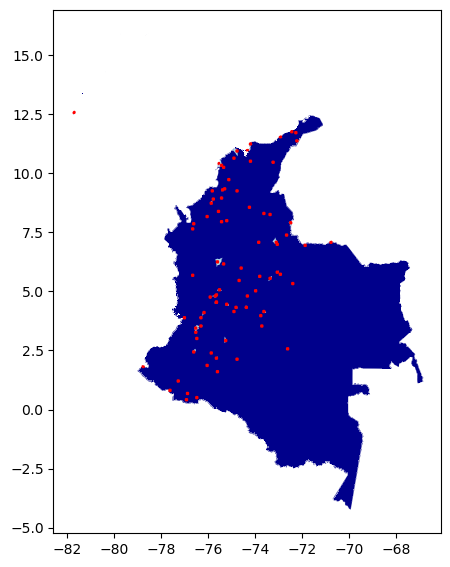

In [141]:
fig, ax= plt.subplots(figsize=(5,10))

grid.plot(ax=ax, color = 'darkblue', zorder=0)

gdf_fua.plot(ax=ax, color='lightblue', zorder=1)

centres = grid.iloc[index_fuas]
centres.buffer(.05).plot(ax=ax, fc='red', zorder=2)

plt.show()


In [142]:
def compute_flows(df_mov_evo, flow_type):

    if flow_type == 'outflows':
        df_flows = pd.DataFrame({'O': np.unique(df_mov_evo['O'])})
    elif flow_type == 'inflows':
        df_flows = pd.DataFrame({'D': np.unique(df_mov_evo['D'])})
        
    df_flows_add = pd.DataFrame({column: [np.nan for i in range(len(df_flows))] for column in df_mov_evo.columns[2:]})

    df_flows = pd.concat([df_flows, df_flows_add], axis=1)   

    for i in range(len(df_flows)):
        if flow_type == 'outflows':
            ID = df_flows.loc[i,'O']
            df = df_mov_evo[df_mov_evo['O']==ID]
        elif flow_type == 'inflows':
            ID = df_flows.loc[i,'D']
            df = df_mov_evo[df_mov_evo['D']==ID]
        
        for column in df_flows.columns[1:]:
            to_sum = []
            for x in df[column]:
                if pd.isna(x) == False:
                    to_sum.append(x)
            if len(to_sum) == 0:
                df_flows.loc[i, column] = np.nan
            else:
                flow = np.sum(df[column])
                df_flows.loc[i, column] = flow
        
    return df_flows

In [143]:
def compute_df_ts(df_flows, df_flows_baseline, initial_col):

    evo_movs = []
    evo_movs_baseline = []
    for column in df_flows.columns[initial_col:]:
        sum_evo_movs = []
        sum_evo_movs_baseline = []
        for i in range(0,len(df_flows)):
            if pd.isna(df_flows.loc[i, column]) == False and pd.isna(df_flows_baseline.loc[i, column]) == False:
                sum_evo_movs.append(df_flows.loc[i, column])
                sum_evo_movs_baseline.append(df_flows_baseline.loc[i, column])
        if len(sum_evo_movs) > 0:
            evo_movs.append(np.sum(sum_evo_movs))
            evo_movs_baseline.append(np.sum(sum_evo_movs_baseline))
        else:
            evo_movs.append(np.nan)
            evo_movs_baseline.append(np.nan)

    df_ts = pd.DataFrame({'date': df_flows.columns[initial_col:], 'movements': evo_movs, 'baseline': evo_movs_baseline})

    # Replace zeros and infs by NaNs, then replace NaNs by average of closest 15 observations in time series
    for i in range(len(df_ts)):
        if df_ts.loc[i, 'movements'] == 0:
            df_ts.loc[i, 'movements'] = np.nan
    df_ts.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_ts['isna'] = df_ts['movements'].isna()
    df_ts['movements_fill'] = df_ts['movements']
    df_ts_dropna = df_ts.dropna()
    df_ts_dropna
    indexes = df_ts[df_ts['isna']==True].index
    for target_index in indexes:
        # Calculate the absolute difference between the row indices and the target index
        df_ts_dropna.loc[:,'diff'] = list(abs(df_ts_dropna.index - target_index))
        # Sort the DataFrame by this difference
        df_sorted = df_ts_dropna.sort_values(by='diff')
        # Select the top 15 rows
        nearest_rows = df_sorted.head(15)
        # Drop the 'diff' column if you don't need it anymore
        df_ts.loc[target_index, 'movements_fill'] = np.mean(nearest_rows['movements'])
        df_ts_dropna.drop(columns=['diff'])
    df_ts.loc[:,'rolling'] = df_ts['movements_fill'].rolling(window=15).mean()


    # Replace zeros by NaNs, then replace NaNs by average of closest 15 observations in time series
    for i in range(len(df_ts)):
        if df_ts.loc[i, 'baseline'] == 0:
            df_ts.loc[i, 'baseline'] = np.nan
    df_ts['isna'] = df_ts['baseline'].isna()
    df_ts['baseline_fill'] = df_ts['baseline']
    df_ts_dropna = df_ts.dropna()
    df_ts_dropna
    indexes = df_ts[df_ts['isna']==True].index
    for target_index in indexes:
        # Calculate the absolute difference between the row indices and the target index
        df_ts_dropna.loc[:,'diff'] = list(abs(df_ts_dropna.index - target_index))
        # Sort the DataFrame by this difference
        df_sorted = df_ts_dropna.sort_values(by='diff')
        # Select the top 15 rows
        nearest_rows = df_sorted.head(15)
        # Drop the 'diff' column if you don't need it anymore
        df_ts.loc[target_index, 'baseline_fill'] = np.mean(nearest_rows['baseline'])
        df_ts_dropna.drop(columns=['diff'])
    df_ts.loc[:,'rolling_baseline'] = df_ts['baseline_fill'].rolling(window=15).mean()
    
    df_ts['perchange'] = [(df_ts.loc[i,'movements_fill']-df_ts.loc[i,'baseline_fill'])/df_ts.loc[i,'baseline_fill']*100 for i in range(len(df_ts))]
    df_ts.loc[:,'rolling_perchange'] = df_ts['perchange'].rolling(window=30).mean()

    return df_ts

In [144]:
def compute_df_ts_weekly(df_ts):
    
    df_ts_weekly = pd.DataFrame({'week_no': range(int(len(df_ts)/7))})
    df_ts_weekly['week_start'] = [df_ts.loc[i*7, 'date'] for i in range(int(len(df_ts)/7))]
    df_ts_weekly['movements'] = [np.sum(df_ts.loc[i*7:(i+1)*7-1, 'movements']) for i in range(int(len(df_ts)/7))]
    df_ts_weekly['baseline'] = [np.sum(df_ts.loc[i*7:(i+1)*7-1, 'baseline']) for i in range(int(len(df_ts)/7))]
    df_ts_weekly['movements_fill'] = [np.sum(df_ts.loc[i*7:(i+1)*7-1, 'movements_fill']) for i in range(int(len(df_ts)/7))]
    df_ts_weekly['baseline_fill'] = [np.sum(df_ts.loc[i*7:(i+1)*7-1, 'baseline_fill']) for i in range(int(len(df_ts)/7))]
    df_ts_weekly['perchange'] = [(df_ts_weekly.loc[i,'movements_fill']-df_ts_weekly.loc[i,'baseline_fill'])/df_ts_weekly.loc[i,'baseline_fill']*100 for i in range(len(df_ts_weekly))]

    return df_ts_weekly

In [145]:
df_stringency = pd.read_csv(wd + '/data/inputs/covid-stringency/owid-covid-data.csv')
df_stringency = df_stringency[df_stringency['location'] == str(country).capitalize()].reset_index(drop=True)                     
             

### Evolution by day or by week, distance >= 0 or > 0, data raw or processed

In [146]:
dist = True
raw = False
adjust = True

if dist == True:
    dist_suffix = '_dist'
else:
    dist_suffix = ''
if raw == True:
    raw_suffix = '_raw'
else:
    raw_suffix = '' 
    if adjust == True:
        adjust_suffix = '_adjust'
    else:
        adjust_suffix = ''
    
    
df_mov_evo = pd.read_csv(wd + '/data/outputs/' + country_short + '/evo/mov_evo' + dist_suffix + raw_suffix + adjust_suffix + '.csv').drop('Unnamed: 0', axis=1)
df_mov_evo_baseline = pd.read_csv(wd + '/data/outputs/' + country_short + '/evo/mov_evo_baseline' + dist_suffix + raw_suffix + '.csv').drop('Unnamed: 0', axis=1)



In [147]:
flows = 'movs' # change to movs, inflows or outflows

if flows == 'inflows' or flows == 'outflows':
    df_flows = pd.read_csv(wd + '/data/outputs/' + country_short + '/mov-analysis/' + flows + dist + raw + adjust + '.csv').drop('Unnamed: 0', axis=1)
    df_flows_baseline = pd.read_csv(wd + '/data/outputs/' + country_short + '/mov-analysis/' + flows + '_baseline' + dist + raw + '.csv').drop('Unnamed: 0', axis=1)
    initial_col = 1
else:
    df_flows = df_mov_evo
    df_flows_baseline = df_mov_evo_baseline
    initial_col = 2

### Set distance within a radius of 100 of FUAs centres? True for YES, False for NO

In [148]:
radius = True

if radius == True:
    radius_suffix = '_radius'
else:
    radius_suffix = ''

In [149]:
mask = df_flows['O'].isin(gdf_fua['centre']) | df_flows['D'].isin(gdf_fua['centre'])
df_flows_fua = df_flows[mask].reset_index(drop=True)
df_flows_fua_baseline = df_flows_baseline[mask].reset_index(drop=True)

index_to_drop = []

if radius == True:
    for i in range(len(df_flows_fua)):
        O = df_flows_fua.loc[i, 'O']
        D = df_flows_fua.loc[i, 'D']
        dist = baseline_mov_dist[(baseline_mov_dist['O']==O) & 
                  (baseline_mov_dist['D']==D) & 
                  (baseline_mov_dist['wday']==0)].reset_index(drop=True).loc[0, 'dist']
        if dist >= 100000:
            index_to_drop.append(i)

df_flows_fua = df_flows_fua.drop(index_to_drop).reset_index(drop=True)  
df_flows_fua_baseline = df_flows_fua_baseline.drop(index_to_drop).reset_index(drop=True)  
        
initial_col = 4

In [150]:
# we create a new column to see what cell we need to classify (the one that is not the FUA centre)

classify = []
anchor = []
for i in range(len(df_flows_fua)):
    if df_flows_fua.loc[i, 'O'] in list(gdf_fua['centre']):
        if df_flows_fua.loc[i, 'D'] in list(gdf_fua['centre']):
            random_choice = random.choice([0, 1])
            classify.append(df_flows_fua.loc[i, df_flows_fua.columns[random_choice]])
            anchor.append(df_flows_fua.columns[random_choice])
        else: 
            classify.append(df_flows_fua.loc[i, 'D'])
            anchor.append('O')
    else:
        classify.append(df_flows_fua.loc[i, 'O'])
        anchor.append('D')

df_flows_fua.insert(2, 'classify', classify)
df_flows_fua.insert(3, 'anchor', anchor)
df_flows_fua_baseline.insert(2, 'classify', classify)
df_flows_fua_baseline.insert(3, 'anchor', anchor)

### By density class

In [151]:
n_class_density = 5

breaks_density = jenkspy.jenks_breaks(baseline_pop_imput.dropna(subset=['density'])['density'], n_classes=n_class_density)
breaks_density[0] = breaks_density[0]-10**(-10)
baseline_pop_imput['class_density'] = pd.qcut(baseline_pop_imput['density'], q=n_class_density, labels=[i for i in range(n_class_density)])#, bins=breaks_density, labels=[i for i in range(n_class_density)])
baseline_pop_imput['class_density'] = pd.cut(baseline_pop_imput['density'], bins=breaks_density, labels=[i for i in range(n_class_density)])
baseline_pop_imput['class_density'] = pd.to_numeric(baseline_pop_imput['class_density'])


In [152]:
class_density = np.unique(baseline_pop_imput['class_density'])
n_class_density = len(class_density[~np.isnan(class_density)])

In [153]:
df_ts_weekly_inflows_class_density = np.zeros((n_class_density, int((len(df_flows_fua.columns)-4)/7)))
df_ts_weekly_inflows_baseline_class_density = np.zeros((n_class_density, int((len(df_flows_fua.columns)-4)/7)))

df_ts_weekly_outflows_class_density = np.zeros((n_class_density, int((len(df_flows_fua.columns)-4)/7)))
df_ts_weekly_outflows_baseline_class_density = np.zeros((n_class_density, int((len(df_flows_fua.columns)-4)/7)))

for i in range(n_class_density):

    indexes = set(baseline_pop_imput[baseline_pop_imput['class_density']==i].index)
    
    mask_inflows = (df_flows_fua['classify'].isin(indexes)) & (df_flows_fua['anchor'] == 'D')
    df_inflows_class_density = df_flows_fua[mask_inflows].reset_index(drop=True)
    df_inflows_class_density_baseline = df_flows_fua_baseline[mask_inflows].reset_index(drop=True)
    
    df_ts_class_density = compute_df_ts(df_inflows_class_density, df_inflows_class_density_baseline, initial_col)
    df_ts_weekly_inflows = compute_df_ts_weekly(df_ts_class_density)
    df_ts_weekly_inflows_class_density[i, :] = df_ts_weekly_inflows['movements']
    df_ts_weekly_inflows_baseline_class_density[i, :] = df_ts_weekly_inflows['baseline']
    
    mask_outflows = (df_flows_fua['classify'].isin(indexes)) & (df_flows_fua['anchor'] == 'O')
    df_outflows_class_density = df_flows_fua[mask_outflows].reset_index(drop=True)
    df_outflows_class_density_baseline = df_flows_fua_baseline[mask_outflows].reset_index(drop=True)
    
    df_ts_class_density = compute_df_ts(df_outflows_class_density, df_outflows_class_density_baseline, initial_col)
    df_ts_weekly_outflows = compute_df_ts_weekly(df_ts_class_density)
    df_ts_weekly_outflows_class_density[i, :] = df_ts_weekly_outflows['movements']
    df_ts_weekly_outflows_baseline_class_density[i, :] = df_ts_weekly_outflows['baseline']



/var/folders/79/65l52xsj7vq_4_t_l6k5bl2c0000gn/T/ipykernel_20139/4102562250.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ts_dropna.loc[:,'diff'] = list(abs(df_ts_dropna.index - target_index))
/var/folders/79/65l52xsj7vq_4_t_l6k5bl2c0000gn/T/ipykernel_20139/4102562250.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ts_dropna.loc[:,'diff'] = list(abs(df_ts_dropna.index - target_index))
/var/folders/79/65l52xsj7vq_4_t_l6k5bl2c0000gn/T/ipykernel_20139/4102562250.py:33: SettingWithCopyWarning:

/var/folders/79/65l52xsj7vq_4_t_l6k5bl2c0000gn/T/ipykernel_20139/4102562250.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ts_dropna.loc[:,'diff'] = list(abs(df_ts_dropna.index - target_index))
/var/folders/79/65l52xsj7vq_4_t_l6k5bl2c0000gn/T/ipykernel_20139/4102562250.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ts_dropna.loc[:,'diff'] = list(abs(df_ts_dropna.index - target_index))
/var/folders/79/65l52xsj7vq_4_t_l6k5bl2c0000gn/T/ipykernel_20139/4102562250.py:33: SettingWithCopyWarning:

/var/folders/79/65l52xsj7vq_4_t_l6k5bl2c0000gn/T/ipykernel_20139/4102562250.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ts_dropna.loc[:,'diff'] = list(abs(df_ts_dropna.index - target_index))
/var/folders/79/65l52xsj7vq_4_t_l6k5bl2c0000gn/T/ipykernel_20139/4102562250.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ts_dropna.loc[:,'diff'] = list(abs(df_ts_dropna.index - target_index))
/var/folders/79/65l52xsj7vq_4_t_l6k5bl2c0000gn/T/ipykernel_20139/4102562250.py:33: SettingWithCopyWarning:

/var/folders/79/65l52xsj7vq_4_t_l6k5bl2c0000gn/T/ipykernel_20139/4102562250.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ts_dropna.loc[:,'diff'] = list(abs(df_ts_dropna.index - target_index))
/var/folders/79/65l52xsj7vq_4_t_l6k5bl2c0000gn/T/ipykernel_20139/4102562250.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ts_dropna.loc[:,'diff'] = list(abs(df_ts_dropna.index - target_index))
/var/folders/79/65l52xsj7vq_4_t_l6k5bl2c0000gn/T/ipykernel_20139/4102562250.py:33: SettingWithCopyWarning:

/var/folders/79/65l52xsj7vq_4_t_l6k5bl2c0000gn/T/ipykernel_20139/4102562250.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ts_dropna.loc[:,'diff'] = list(abs(df_ts_dropna.index - target_index))
/var/folders/79/65l52xsj7vq_4_t_l6k5bl2c0000gn/T/ipykernel_20139/4102562250.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ts_dropna.loc[:,'diff'] = list(abs(df_ts_dropna.index - target_index))
/var/folders/79/65l52xsj7vq_4_t_l6k5bl2c0000gn/T/ipykernel_20139/4102562250.py:33: SettingWithCopyWarning:

/var/folders/79/65l52xsj7vq_4_t_l6k5bl2c0000gn/T/ipykernel_20139/4102562250.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ts_dropna.loc[:,'diff'] = list(abs(df_ts_dropna.index - target_index))
/var/folders/79/65l52xsj7vq_4_t_l6k5bl2c0000gn/T/ipykernel_20139/4102562250.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ts_dropna.loc[:,'diff'] = list(abs(df_ts_dropna.index - target_index))
/var/folders/79/65l52xsj7vq_4_t_l6k5bl2c0000gn/T/ipykernel_20139/4102562250.py:33: SettingWithCopyWarning:

/var/folders/79/65l52xsj7vq_4_t_l6k5bl2c0000gn/T/ipykernel_20139/4102562250.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ts_dropna.loc[:,'diff'] = list(abs(df_ts_dropna.index - target_index))
/var/folders/79/65l52xsj7vq_4_t_l6k5bl2c0000gn/T/ipykernel_20139/4102562250.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ts_dropna.loc[:,'diff'] = list(abs(df_ts_dropna.index - target_index))
/var/folders/79/65l52xsj7vq_4_t_l6k5bl2c0000gn/T/ipykernel_20139/4102562250.py:33: SettingWithCopyWarning:

/var/folders/79/65l52xsj7vq_4_t_l6k5bl2c0000gn/T/ipykernel_20139/4102562250.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ts_dropna.loc[:,'diff'] = list(abs(df_ts_dropna.index - target_index))
/var/folders/79/65l52xsj7vq_4_t_l6k5bl2c0000gn/T/ipykernel_20139/4102562250.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ts_dropna.loc[:,'diff'] = list(abs(df_ts_dropna.index - target_index))
/var/folders/79/65l52xsj7vq_4_t_l6k5bl2c0000gn/T/ipykernel_20139/4102562250.py:33: SettingWithCopyWarning:

/var/folders/79/65l52xsj7vq_4_t_l6k5bl2c0000gn/T/ipykernel_20139/4102562250.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ts_dropna.loc[:,'diff'] = list(abs(df_ts_dropna.index - target_index))
/var/folders/79/65l52xsj7vq_4_t_l6k5bl2c0000gn/T/ipykernel_20139/4102562250.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ts_dropna.loc[:,'diff'] = list(abs(df_ts_dropna.index - target_index))
/var/folders/79/65l52xsj7vq_4_t_l6k5bl2c0000gn/T/ipykernel_20139/4102562250.py:33: SettingWithCopyWarning:

/var/folders/79/65l52xsj7vq_4_t_l6k5bl2c0000gn/T/ipykernel_20139/4102562250.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ts_dropna.loc[:,'diff'] = list(abs(df_ts_dropna.index - target_index))
/var/folders/79/65l52xsj7vq_4_t_l6k5bl2c0000gn/T/ipykernel_20139/4102562250.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ts_dropna.loc[:,'diff'] = list(abs(df_ts_dropna.index - target_index))
/var/folders/79/65l52xsj7vq_4_t_l6k5bl2c0000gn/T/ipykernel_20139/4102562250.py:33: SettingWithCopyWarning:

/var/folders/79/65l52xsj7vq_4_t_l6k5bl2c0000gn/T/ipykernel_20139/3781741229.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = plt.cm.get_cmap('viridis')


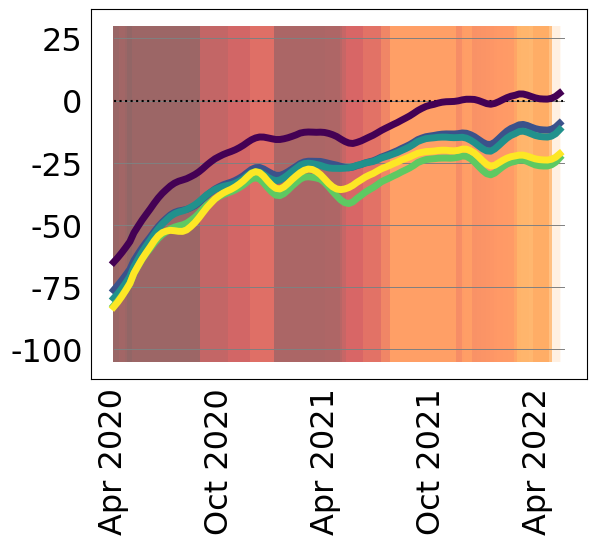

In [154]:
fig, ax = plt.subplots()

ax.tick_params(axis = 'both', which = 'both', width = 0, length = 0, color = 'k', labelsize=20, pad=9)

viridis = plt.cm.get_cmap('viridis')
norm = plt.Normalize(0, n_class_density-1)

maxima = []
minima = []

for i in range(n_class_density):
    
    color = viridis(norm(i)) 
    inflows_class_density = df_ts_weekly_inflows_class_density[i, :]
    inflows_baseline_class_density = df_ts_weekly_inflows_baseline_class_density[i, :] 
    inflows_perchange = [(inflows_class_density[i]-inflows_baseline_class_density[i])/inflows_baseline_class_density[i]*100 for i in range(len(inflows_baseline_class_density))]
    df_ts_weekly_class_density_plot = pd.DataFrame({'perchange_class': inflows_perchange})
    
#     df_ts_weekly_class_density_plot.loc[:,'rolling_perchange'] = df_ts_weekly_class_density_plot['perchange_class'].rolling(window=6).mean()
#     ax.plot(np.arange(len(df_ts_weekly_class_density_plot['rolling_perchange']))*7, df_ts_weekly_class_density_plot['rolling_perchange'], color=color, lw=2, zorder=3)

    df_ts_weekly_class_density_plot['rolling_perchange'] = df_ts_weekly_class_density_plot['perchange_class'].ewm(span=10).mean()
    df_ts_weekly_class_density_plot['rolling_perchange'] = scipy.signal.savgol_filter(df_ts_weekly_class_density_plot['rolling_perchange'], window_length=10, polyorder=3)
    ax.plot(np.arange(len(df_ts_weekly_class_density_plot['rolling_perchange']))*7, df_ts_weekly_class_density_plot['rolling_perchange'], color=color, lw=5, zorder=3)

    maxima.append(max(df_ts_weekly_class_density_plot['rolling_perchange']))
    minima.append(min(df_ts_weekly_class_density_plot['rolling_perchange']))
    
ax.plot(np.arange(len(df_ts_weekly_class_density_plot['rolling_perchange'])*7), np.zeros(len(df_ts_weekly_class_density_plot['rolling_perchange'])*7), linestyle=':', color='k')

stringencies = []
for date in df_ts_class_density['date']:
    stringencies.append(df_stringency[df_stringency['date']==date].reset_index(drop=True).loc[0,'stringency_index'])

ymin = -105
ymax = 30

for k in range(len(df_ts_class_density)):
    try:
        rgba = matplotlib.cm.gist_heat(1-(stringencies[k]-min(stringencies))/max(stringencies))
    except:
        rgba = matplotlib.cm.gist_heat(1-(stringencies[k-1]-min(stringencies))/max(stringencies))
    x = [k-.50, k+.50]
    ax.fill_between(x, ymin, ymax, color=rgba, alpha=0.6, edgecolor='None', linewidth=0, zorder=0)

xticks = []
xticks_labels = ['Apr 2020', 'Oct 2020', 'Apr 2021', 'Oct 2021', 'Apr 2022']
for i in range(0, len(df_ts_class_density['rolling_perchange'])):
    if i%183 == 0:
        xticks.append(i)
ax.set_xticks(xticks, xticks_labels)
ax.tick_params(axis = 'x', bottom=True, labelsize = 23, pad=6, rotation=90)
    
yticks = []
for i in range(ymin, ymax):
    if i%25 == 0:
        yticks.append(i)
ax.set_yticks(yticks, yticks)
for y in yticks:
    ax.plot([0, len(df_ts_class_density['rolling_perchange'])],[y,y], color='gray', lw=0.7, zorder=0)
ax.tick_params(axis = 'y', labelsize = 23, pad=6, rotation=0)
    
plt.savefig(wd + '/plots/evolution/' + flows + '/by-density/' + country_short + '/evo_inflows' + capital_suffix + dist_suffix + raw_suffix + adjust_suffix + radius_suffix + '.pdf', bbox_inches = 'tight')

plt.show()

/var/folders/79/65l52xsj7vq_4_t_l6k5bl2c0000gn/T/ipykernel_20139/1734305756.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = plt.cm.get_cmap('viridis')


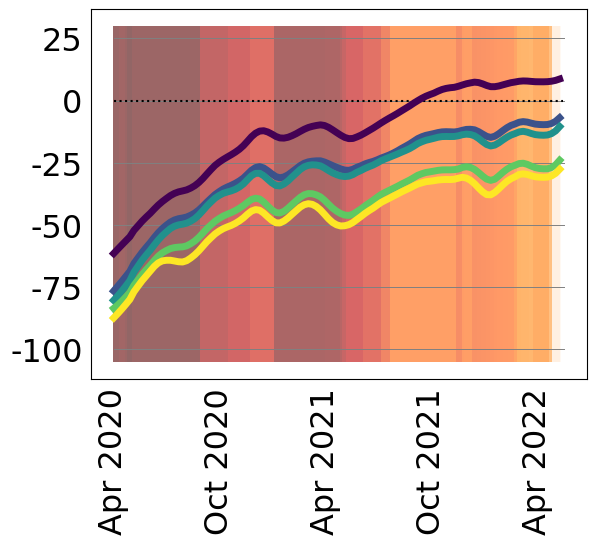

In [155]:
fig, ax = plt.subplots()

ax.tick_params(axis = 'both', which = 'both', width = 0, length = 0, color = 'k', labelsize=20, pad=9)

viridis = plt.cm.get_cmap('viridis')
norm = plt.Normalize(0, n_class_density-1)

maxima = []
minima = []

for i in range(n_class_density):
    
    color = viridis(norm(i)) 
    outflows_class_density = df_ts_weekly_outflows_class_density[i, :]
    outflows_baseline_class_density = df_ts_weekly_outflows_baseline_class_density[i, :] 
    outflows_perchange = [(outflows_class_density[i]-outflows_baseline_class_density[i])/outflows_baseline_class_density[i]*100 for i in range(len(outflows_baseline_class_density))]
    df_ts_weekly_class_density_plot = pd.DataFrame({'perchange_class': outflows_perchange})
    
#     df_ts_weekly_class_density_plot.loc[:,'rolling_perchange'] = df_ts_weekly_class_density_plot['perchange_class'].rolling(window=6).mean()
#     ax.plot(np.arange(len(df_ts_weekly_class_density_plot['rolling_perchange']))*7, df_ts_weekly_class_density_plot['rolling_perchange'], color=color, lw=2, zorder=3)

    df_ts_weekly_class_density_plot['rolling_perchange'] = df_ts_weekly_class_density_plot['perchange_class'].ewm(span=10).mean()
    df_ts_weekly_class_density_plot['rolling_perchange'] = scipy.signal.savgol_filter(df_ts_weekly_class_density_plot['rolling_perchange'], window_length=10, polyorder=3)
    ax.plot(np.arange(len(df_ts_weekly_class_density_plot['rolling_perchange']))*7, df_ts_weekly_class_density_plot['rolling_perchange'], color=color, lw=5, zorder=3)

    maxima.append(max(df_ts_weekly_class_density_plot['rolling_perchange']))
    minima.append(min(df_ts_weekly_class_density_plot['rolling_perchange']))
    
ax.plot(np.arange(len(df_ts_weekly_class_density_plot['rolling_perchange'])*7), np.zeros(len(df_ts_weekly_class_density_plot['rolling_perchange'])*7), linestyle=':', color='k')

stringencies = []
for date in df_ts_class_density['date']:
    stringencies.append(df_stringency[df_stringency['date']==date].reset_index(drop=True).loc[0,'stringency_index'])

ymin = -105
ymax = 30

for k in range(len(df_ts_class_density)):
    try:
        rgba = matplotlib.cm.gist_heat(1-(stringencies[k]-min(stringencies))/max(stringencies))
    except:
        rgba = matplotlib.cm.gist_heat(1-(stringencies[k-1]-min(stringencies))/max(stringencies))
    x = [k-.50, k+.50]
    ax.fill_between(x, ymin, ymax, color=rgba, alpha=0.6, edgecolor='None', linewidth=0, zorder=0)

xticks = []
xticks_labels = ['Apr 2020', 'Oct 2020', 'Apr 2021', 'Oct 2021', 'Apr 2022']
for i in range(0, len(df_ts_class_density['rolling_perchange'])):
    if i%183 == 0:
        xticks.append(i)
ax.set_xticks(xticks, xticks_labels)
ax.tick_params(axis = 'x', bottom=True, labelsize = 23, pad=6, rotation=90)
    
yticks = []
for i in range(ymin, ymax):
    if i%25 == 0:
        yticks.append(i)
ax.set_yticks(yticks, yticks)
for y in yticks:
    ax.plot([0, len(df_ts_class_density['rolling_perchange'])],[y,y], color='gray', lw=0.7, zorder=0)
ax.tick_params(axis = 'y', labelsize = 23, pad=6, rotation=0)
    
plt.savefig(wd + '/plots/evolution/' + flows + '/by-density/' + country_short + '/evo_outflows' + capital_suffix + dist_suffix + raw_suffix + adjust_suffix + radius_suffix + '.pdf', bbox_inches = 'tight')

plt.show()

/var/folders/79/65l52xsj7vq_4_t_l6k5bl2c0000gn/T/ipykernel_20139/4089673568.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = plt.cm.get_cmap('viridis')


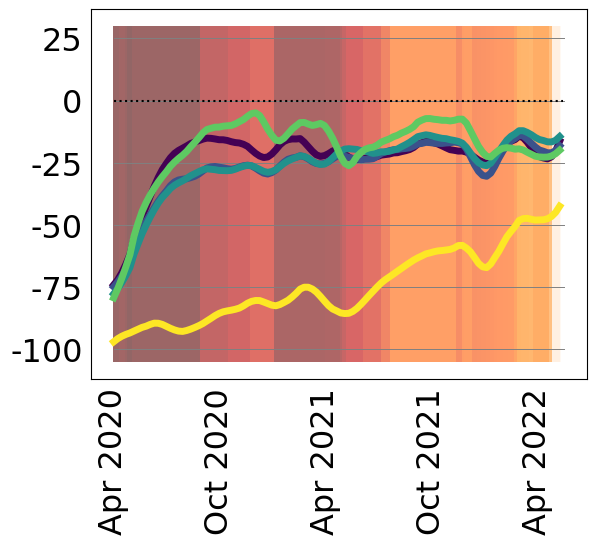

In [156]:
fig, ax = plt.subplots()

ax.tick_params(axis = 'both', which = 'both', width = 0, length = 0, color = 'k', labelsize=20, pad=9)

viridis = plt.cm.get_cmap('viridis')
norm = plt.Normalize(0, n_class_density-1)

maxima = []
minima = []

for i in range(n_class_density):
    
    color = viridis(norm(i)) 
    netflows_class_density = df_ts_weekly_inflows_class_density[i, :] - df_ts_weekly_outflows_class_density[i, :]
    netflows_baseline_class_density = df_ts_weekly_inflows_baseline_class_density[i, :] - df_ts_weekly_outflows_baseline_class_density[i, :]
    netflows_perchange = [(netflows_class_density[i]-netflows_baseline_class_density[i])/netflows_baseline_class_density[i]*100 for i in range(len(netflows_baseline_class_density))]
    df_ts_weekly_class_density_plot = pd.DataFrame({'perchange_class': netflows_perchange})
    
#     df_ts_weekly_class_density_plot.loc[:,'rolling_perchange'] = df_ts_weekly_class_density_plot['perchange_class'].rolling(window=6).mean()
#     ax.plot(np.arange(len(df_ts_weekly_class_density_plot['rolling_perchange']))*7, df_ts_weekly_class_density_plot['rolling_perchange'], color=color, lw=2, zorder=3)

    df_ts_weekly_class_density_plot['rolling_perchange'] = df_ts_weekly_class_density_plot['perchange_class'].ewm(span=10).mean()
    df_ts_weekly_class_density_plot['rolling_perchange'] = scipy.signal.savgol_filter(df_ts_weekly_class_density_plot['rolling_perchange'], window_length=10, polyorder=3)
    ax.plot(np.arange(len(df_ts_weekly_class_density_plot['rolling_perchange']))*7, df_ts_weekly_class_density_plot['rolling_perchange'], color=color, lw=5, zorder=3)

    maxima.append(max(df_ts_weekly_class_density_plot['rolling_perchange']))
    minima.append(min(df_ts_weekly_class_density_plot['rolling_perchange']))
    
ax.plot(np.arange(len(df_ts_weekly_class_density_plot['rolling_perchange'])*7), np.zeros(len(df_ts_weekly_class_density_plot['rolling_perchange'])*7), linestyle=':', color='k')

stringencies = []
for date in df_ts_class_density['date']:
    stringencies.append(df_stringency[df_stringency['date']==date].reset_index(drop=True).loc[0,'stringency_index'])

ymin = -105
ymax = 30

for k in range(len(df_ts_class_density)):
    try:
        rgba = matplotlib.cm.gist_heat(1-(stringencies[k]-min(stringencies))/max(stringencies))
    except:
        rgba = matplotlib.cm.gist_heat(1-(stringencies[k-1]-min(stringencies))/max(stringencies))
    x = [k-.50, k+.50]
    ax.fill_between(x, ymin, ymax, color=rgba, alpha=0.6, edgecolor='None', linewidth=0, zorder=0)

xticks = []
xticks_labels = ['Apr 2020', 'Oct 2020', 'Apr 2021', 'Oct 2021', 'Apr 2022']
for i in range(0, len(df_ts_class_density['rolling_perchange'])):
    if i%183 == 0:
        xticks.append(i)
ax.set_xticks(xticks, xticks_labels)
ax.tick_params(axis = 'x', bottom=True, labelsize = 23, pad=6, rotation=90)
    
yticks = []
for i in range(ymin, ymax):
    if i%25 == 0:
        yticks.append(i)
ax.set_yticks(yticks, yticks)
for y in yticks:
    ax.plot([0, len(df_ts_class_density['rolling_perchange'])],[y,y], color='gray', lw=0.7, zorder=0)
ax.tick_params(axis = 'y', labelsize = 23, pad=6, rotation=0)
    
plt.savefig(wd + '/plots/evolution/' + flows + '/by-density/' + country_short + '/evo_netflows' + capital_suffix + dist_suffix + raw_suffix + adjust_suffix + radius_suffix + '.pdf', bbox_inches = 'tight')

plt.show()

/var/folders/79/65l52xsj7vq_4_t_l6k5bl2c0000gn/T/ipykernel_20139/2263433330.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = plt.cm.get_cmap('viridis')


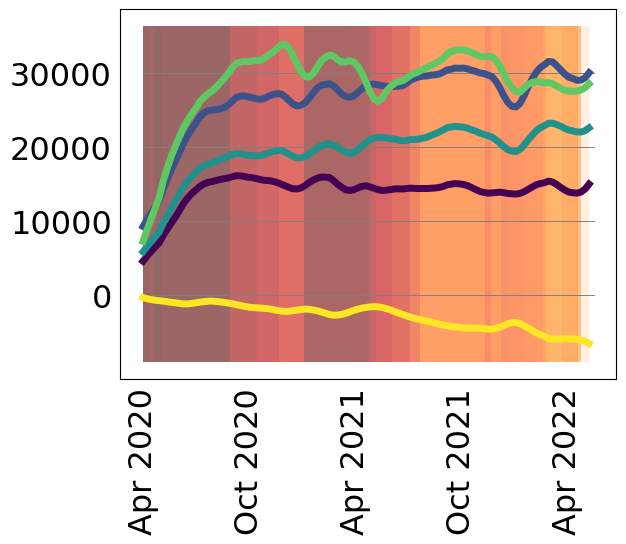

In [157]:
fig, ax = plt.subplots()

ax.tick_params(axis = 'both', which = 'both', width = 0, length = 0, color = 'k', labelsize=20, pad=9)

viridis = plt.cm.get_cmap('viridis')
norm = plt.Normalize(0, n_class_density-1)

maxima = []
minima = []

for i in range(n_class_density):

    
    color = viridis(norm(i)) 
    netflows_class_density = df_ts_weekly_inflows_class_density[i, :] - df_ts_weekly_outflows_class_density[i, :]
    netflows_baseline_class_density = df_ts_weekly_inflows_baseline_class_density[i, :] - df_ts_weekly_outflows_baseline_class_density[i, :]
    netflows_perchange = [netflows_class_density[i] for i in range(len(netflows_class_density))]
    df_ts_weekly_class_density_plot = pd.DataFrame({'perchange_class': netflows_perchange})
    netflows_baseline_perchange = [netflows_baseline_class_density[i] for i in range(len(netflows_baseline_class_density))]
    df_ts_weekly_baseline_class_density_plot = pd.DataFrame({'perchange_class': netflows_baseline_perchange})
    
#     df_ts_weekly_class_density_plot.loc[:,'rolling_perchange'] = df_ts_weekly_class_density_plot['perchange_class'].rolling(window=6).mean()
#     ax.plot(np.arange(len(df_ts_weekly_class_density_plot['rolling_perchange']))*7, df_ts_weekly_class_density_plot['rolling_perchange'], color=color, lw=2, zorder=3)

    df_ts_weekly_class_density_plot['rolling_perchange'] = df_ts_weekly_class_density_plot['perchange_class'].ewm(span=10).mean()
    df_ts_weekly_class_density_plot['rolling_perchange'] = scipy.signal.savgol_filter(df_ts_weekly_class_density_plot['rolling_perchange'], window_length=10, polyorder=3)
    df_ts_weekly_baseline_class_density_plot['rolling_perchange'] = df_ts_weekly_baseline_class_density_plot['perchange_class'].ewm(span=10).mean()
    df_ts_weekly_baseline_class_density_plot['rolling_perchange'] = scipy.signal.savgol_filter(df_ts_weekly_baseline_class_density_plot['rolling_perchange'], window_length=10, polyorder=3)
    ax.plot(np.arange(len(df_ts_weekly_class_density_plot['rolling_perchange']))*7, df_ts_weekly_class_density_plot['rolling_perchange'], color=color, lw=5, zorder=3)
#     ax.plot(np.arange(len(df_ts_weekly_baseline_class_density_plot['rolling_perchange']))*7, df_ts_weekly_baseline_class_density_plot['rolling_perchange'], color=color, lw=2, zorder=3, linestyle=':')

    maxima.append(max(df_ts_weekly_class_density_plot['rolling_perchange']))
    minima.append(min(df_ts_weekly_class_density_plot['rolling_perchange']))
#     maxima.append(max(df_ts_weekly_baseline_class_density_plot['rolling_perchange']))
#     minima.append(min(df_ts_weekly_baseline_class_density_plot['rolling_perchange']))
    
# ax.plot(np.arange(len(df_ts_weekly_class_density_plot['rolling_perchange'])*7), np.zeros(len(df_ts_weekly_class_density_plot['rolling_perchange'])*7), linestyle=':', color='k')

stringencies = []
for date in df_ts_class_density['date']:
    stringencies.append(df_stringency[df_stringency['date']==date].reset_index(drop=True).loc[0,'stringency_index'])

ymin = int(min(minima))-2500
ymax = int(max(maxima))+2500

for k in range(len(df_ts_class_density)):
    try:
        rgba = matplotlib.cm.gist_heat(1-(stringencies[k]-min(stringencies))/max(stringencies))
    except:
        rgba = matplotlib.cm.gist_heat(1-(stringencies[k-1]-min(stringencies))/max(stringencies))
    x = [k-.50, k+.50]
    ax.fill_between(x, ymin, ymax, color=rgba, alpha=0.6, edgecolor='None', linewidth=0, zorder=0)

xticks = []
xticks_labels = ['Apr 2020', 'Oct 2020', 'Apr 2021', 'Oct 2021', 'Apr 2022']
for i in range(0, len(df_ts_class_density['rolling_perchange'])):
    if i%183 == 0:
        xticks.append(i)
ax.set_xticks(xticks, xticks_labels)
ax.tick_params(axis = 'x', bottom=True, labelsize = 23, pad=6, rotation=90)
    
yticks = []
for i in range(ymin, ymax):
    if i%10000 == 0:
        yticks.append(i)
ax.set_yticks(yticks, yticks)
for y in yticks:
    ax.plot([0, len(df_ts_class_density['rolling_perchange'])],[y,y], color='gray', lw=0.7, zorder=0)
ax.tick_params(axis = 'y', labelsize = 23, pad=6, rotation=0)
    
plt.savefig(wd + '/plots/evolution/' + flows + '/by-density/' + country_short + '/evo_netflows_absolute' + capital_suffix + dist_suffix + raw_suffix + adjust_suffix + radius_suffix + '.pdf', bbox_inches = 'tight')

plt.show()